<a href="https://colab.research.google.com/github/jabdurrahmaan/DataScience2021/blob/main/Zero_shot_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

For this zero-shot classification notebook we need the following libraries, including the transformers library from huggingface to apply zero-shot classification and tensorflow to assess the accuracies for multi-labeled predictions.

In [1]:
!pip install transformers

import pandas as pd
import numpy as np
import re
import tensorflow as tf
from transformers import pipeline
from bs4 import BeautifulSoup

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 15.4 MB/s 
     |████████████████████████████████| 596 kB 68.0 MB/s 
     |████████████████████████████████| 6.6 MB 53.8 MB/s 
     |████████████████████████████████| 101 kB 15.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Mounted at /content/drive


#Corpus

In [6]:
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 300)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 300]


In [7]:
df = pd.read_csv("/content/drive/MyDrive/labeled_corpus.csv", index_col = 0)

In [8]:
df = df.dropna() #drop na values (somehow a few remained in the dataset)
rejoined = [row.split(" ") for row in df.labels_str]
df["accept"] = rejoined

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df.head()

,text,accept,labels_str
0,The other part of our data consists of an undirected social graph.,[Data],Data
1,This list of actors can be interpreted to represent the most important barriers to successful software development in Nigeria.,[Definition],Definition
2,"The two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[Method, Theory]",Method Theory
3,"This is supported by a more recent report by START_CITE West and Curtis (2006) END_CITE CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.",[RelationToLiterature],RelationToLiterature
4,", the false noise parameter C was misstated by 0.10 (either all high or all low in a run) except near the end points (C = 0 or 1).",[Definition],Definition


#Text Preprocessing

The following text preprocessing steps will turn every labeled sentence from Prodigy into lower case and remove unnecessary whitespaces. Additionally, we decided to remove any words that contain "CITE" as it has the potential to lower the zero-shot probability scores.

In [10]:
def pre_process(text):
  text = BeautifulSoup(text).get_text()
  # fetch alphabetic characters
  #text = re.sub("[^a-zA-Z]", " ", text)
  # convert text to lower case
  text = text.lower()
  # split text into tokens to remove whitespaces
  tokens = text.split()
  return " ".join(tokens)

In [11]:
df["clean_text"] = df["text"].apply(pre_process)

In [12]:
new_text = [re.sub("start_cite|end_cite|cite_\w+", "", text) for text in df["clean_text"]]
df["new_text"] = new_text

In [13]:
df["text"][3]

'This is supported by a more recent report by  START_CITE West and Curtis (2006) END_CITE  CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [14]:
df["new_text"][3]

'this is supported by a more recent report by  west and curtis (2006)   , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [15]:
df["clean_text"] = df["new_text"].apply(pre_process)

In [16]:
df["clean_text"][3]

'this is supported by a more recent report by west and curtis (2006) , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [17]:
new_text = [re.sub('\s(?=[\.,:;])', '', text) for text in df["clean_text"]]
df["new_text"] = new_text
df["new_text"][3]

'this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [18]:
df

,text,accept,labels_str,clean_text,new_text
0,The other part of our data consists of an undirected social graph.,[Data],Data,the other part of our data consists of an undirected social graph.,the other part of our data consists of an undirected social graph.
1,This list of actors can be interpreted to represent the most important barriers to successful software development in Nigeria.,[Definition],Definition,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.
2,"The two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[Method, Theory]",Method Theory,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","the two samples were compared on all study variables and on age, gender, position, and organizational tenure."
3,"This is supported by a more recent report by START_CITE West and Curtis (2006) END_CITE CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.",[RelationToLiterature],RelationToLiterature,"this is supported by a more recent report by west and curtis (2006) , which found significant differences between women and men academics, including disparities in tenure and salaries.","this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries."
4,", the false noise parameter C was misstated by 0.10 (either all high or all low in a run) except near the end points (C = 0 or 1).",[Definition],Definition,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).",", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1)."
...,...,...,...,...,...
3445,The algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,[Theory],Theory,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.
3446,"We paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interruptions, and the mechanisms that OR personnel deployed to cope with and recover from coordination breakdowns.",[Theory],Theory,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interruptions, and the mechanisms that or personnel deployed to cope with and recover from coordination breakdowns.","we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interruptions, and the mechanisms that or personnel deployed to cope with and recover from coordination breakdowns."
3447,"One major aspect of conscientiousness is a sense of duty that tends to make highly conscientious individuals act on behalf of others rather than maintain a self-centred focus START_CITE (Moon, 2001) END_CITE CITE_b57 . START_CITE Podsakoff et al. (2000) END_CITE CITE_b65 observed that highl...",[RelationToLiterature],RelationToLiterature,"one major aspect of conscientiousness is a sense of duty that tends to make highly conscientious individuals act on behalf of others rather than maintain a self-centred focus (moon, 2001) . podsakoff et al. (2000) observed that highly conscientious individuals demonstrate altruism, which is posi...","one major aspect of conscientiousness is a se

#Zero-shot classification

For the zero-shot classification we will use two different models to classify the labeled sentences from prodigy: BART and DeBERTa. While the chosen BART model is accurate for topic classification and finetuned, the DeBERTa model used below at times outperforms BERT and RoBERTa achieving generally good accuracy results on the familiar NLU datasets.

In [19]:
hypothesis_template = "The research paper section is {}."

#put in the following device = 0 when using GPU
bart = pipeline("zero-shot-classification", model="joeddav/bart-large-mnli-yahoo-answers", device = 0, hypothesis_template = hypothesis_template)
deberta = pipeline("zero-shot-classification", model="Narsil/deberta-large-mnli-zero-cls", device = 0, hypothesis_template = hypothesis_template)

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/729 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Some weights of the model checkpoint at Narsil/deberta-large-mnli-zero-cls were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [20]:
candidate_labels=["goal", "motivation", "research question", "relation to literature", "method", "theory", "definition", "item", "hypothesis", "hypothesis result", "empirical result", "contribution", "limitation", "future work", "data"]

In [21]:
#function to turn output of zero-shot classification from dictionary into dataframe
def zero_shot_classifier(df, classifier, candidate_labels, multi_label_set):
  data = []
  for sentence in df:
    total = classifier(sentence, candidate_labels, multi_label = multi_label_set)
    data.append(total)
  
  result = pd.DataFrame.from_dict(data, orient='columns')
  
  return result

##Original labels

###BART Model

#### Model execution

The zero-shot classification shall be applied first with the BART model but only predicting one label for each labeled sentence.

In [ ]:
#took 24 min on Colab GPU
df_onelabel_bart = zero_shot_classifier(df = df["new_text"], classifier = bart, candidate_labels=candidate_labels, multi_label_set = False)
df_onelabel_bart 

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


,sequence,labels,scores
0,the other part of our data consists of an undirected social graph.,"[data, empirical result, item, method, research question, contribution, theory, definition, hypothesis result, goal, hypothesis, limitation, future work, motivation, relation to literature]","[0.18329249322414398, 0.08793029189109802, 0.08085020631551743, 0.0806816965341568, 0.0732763260602951, 0.06714604049921036, 0.06707784533500671, 0.0589531734585762, 0.05329299345612526, 0.05282801017165184, 0.051843445748090744, 0.042198218405246735, 0.03766772523522377, 0.0321306549012661, 0.030830902978777885]"
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,"[data, contribution, research question, item, method, theory, limitation, definition, empirical result, goal, hypothesis, hypothesis result, future work, motivation, relation to literature]","[0.10155230760574341, 0.0952952653169632, 0.08686939626932144, 0.07704450190067291, 0.0767349824309349, 0.07483500242233276, 0.07195134460926056, 0.06975840032100677, 0.06455088406801224, 0.05847899615764618, 0.056904137134552, 0.05553094670176506, 0.05357165262103081, 0.03753113001585007, 0.019391119480133057]"
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[data, empirical result, research question, contribution, item, method, goal, hypothesis result, definition, theory, hypothesis, relation to literature, future work, limitation, motivation]","[0.13229522109031677, 0.13130299746990204, 0.09494192898273468, 0.09190607815980911, 0.08160978555679321, 0.07329189032316208, 0.06276505440473557, 0.05637962743639946, 0.04781501740217209, 0.04764612764120102, 0.04752299189567566, 0.03977253660559654, 0.032054368406534195, 0.03125070407986641, 0.029445596039295197]"
3,"this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.","[contribution, item, empirical result, data, research question, theory, goal, relation to literature, definition, method, hypothesis result, hypothesis, limitation, motivation, future work]","[0.10750751942396164, 0.10085321217775345, 0.10082905739545822, 0.09457553923130035, 0.08367849141359329, 0.07020168006420135, 0.06875407695770264, 0.06401650607585907, 0.05570639669895172, 0.051016706973314285, 0.04704069346189499, 0.04646450653672218, 0.03934037312865257, 0.03590566664934158, 0.034109607338905334]"
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).","[data, empirical result, method, theory, contribution, research question, definition, item, hypothesis result, hypothesis, limitation, goal, future work, relation to literature, motivation]","[0.1630668044090271, 0.09940808266401291, 0.09631112962961197, 0.08351173251867294, 0.07965273410081863, 0.07414813339710236, 0.0695798248052597, 0.06940969079732895, 0.05850561708211899, 0.04923927038908005, 0.045247048139572144, 0.03795335814356804, 0.03041193261742592, 0.02846493013203144, 0.015089699998497963]"
...,...,...,...
3439,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,"[method, data, theory, item, empirical result, contribution, research question, definition, hypothesis result, hypothesis, limitation, goal, future work, motivation, relation to literature]","[0.14389148354530334, 0.10628359019756317, 0.08955424278974533, 0.07620237022638321, 0.07194332033395767, 0.07179628312587738, 0.06804661452770233, 0.06286090612411499, 0.06110246106982231, 0.0569864921271801, 0.0501084141433239, 0.04680325835943222, 0.043105434626340866, 0.027804138138890266, 0.0235110092908144]"
3440,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences

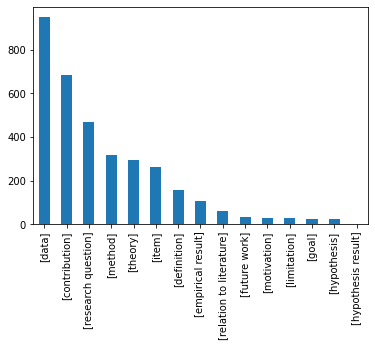

In [ ]:
#plot frequency of predicted labels for one-label bart
freq_labels_onelabelbart = [labels[:1] for labels in df_onelabel_bart.labels]
freq_labels_onelabelbart = pd.DataFrame({'one_label':freq_labels_onelabelbart})
freq_labels_onelabelbart['one_label'].value_counts().plot.bar()

Now, the zero-shot classification shall be applied with the BART model but instead predicting multiple labels for each labeled sentence.

In [ ]:
#took 24 min on Colab GPU
df_multilabel_bart = zero_shot_classifier(df = df["new_text"], classifier = bart, candidate_labels=candidate_labels, multi_label_set = True)
df_multilabel_bart

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


,sequence,labels,scores
0,the other part of our data consists of an undirected social graph.,"[data, empirical result, method, theory, research question, item, contribution, goal, definition, hypothesis result, hypothesis, future work, limitation, motivation, relation to literature]","[0.9354796409606934, 0.8040526509284973, 0.7647650241851807, 0.7421612739562988, 0.7306904196739197, 0.7064001560211182, 0.6989192962646484, 0.6686117649078369, 0.6418256163597107, 0.6133502721786499, 0.5876015424728394, 0.5515915751457214, 0.4910479187965393, 0.45667386054992676, 0.4017384648323059]"
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,"[contribution, data, research question, theory, method, limitation, empirical result, goal, item, future work, definition, hypothesis result, hypothesis, motivation, relation to literature]","[0.7727454900741577, 0.7459300756454468, 0.6966074705123901, 0.6861218214035034, 0.6739178895950317, 0.6495680809020996, 0.620768666267395, 0.6161564588546753, 0.606895387172699, 0.6062252521514893, 0.6042108535766602, 0.479828417301178, 0.46734240651130676, 0.42390990257263184, 0.09447430074214935]"
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[data, empirical result, research question, contribution, method, goal, item, theory, hypothesis result, hypothesis, relation to literature, definition, motivation, future work, limitation]","[0.9209842681884766, 0.9186131954193115, 0.8447135090827942, 0.8357798457145691, 0.8183965682983398, 0.7826624512672424, 0.7727805376052856, 0.6903469562530518, 0.6824692487716675, 0.6269108057022095, 0.6085915565490723, 0.5860893130302429, 0.5202094912528992, 0.49404457211494446, 0.38415995240211487]"
3,"this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.","[empirical result, contribution, data, item, research question, theory, relation to literature, goal, method, definition, hypothesis result, motivation, hypothesis, future work, limitation]","[0.8127262592315674, 0.7991489171981812, 0.7721627354621887, 0.7337754368782043, 0.7128019332885742, 0.7023106217384338, 0.6831337809562683, 0.6710599660873413, 0.5465502738952637, 0.544705331325531, 0.4408862590789795, 0.43117547035217285, 0.417281836271286, 0.3487752377986908, 0.341067910194397]"
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).","[data, empirical result, method, theory, contribution, definition, research question, item, hypothesis result, hypothesis, limitation, goal, future work, relation to literature, motivation]","[0.9321866035461426, 0.8443817496299744, 0.8394008278846741, 0.8275954127311707, 0.8267109394073486, 0.7543668746948242, 0.7406068444252014, 0.7040526270866394, 0.6628038883209229, 0.5887264609336853, 0.5820643901824951, 0.5729063749313354, 0.47939565777778625, 0.39973723888397217, 0.20718449354171753]"
...,...,...,...
3439,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,"[method, data, theory, contribution, empirical result, item, research question, definition, hypothesis result, hypothesis, future work, limitation, goal, motivation, relation to literature]","[0.8286813497543335, 0.7684634923934937, 0.7237498164176941, 0.6515817642211914, 0.6098172068595886, 0.582626461982727, 0.5635679960250854, 0.5516155958175659, 0.5261808633804321, 0.4999596178531647, 0.48332417011260986, 0.47570472955703735, 0.47460609674453735, 0.2734243869781494, 0.159079447388649]"
3440,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interruptions, and the mechanisms that or personnel deployed to cope with an

####Accuracy

To assess the accuracy of the multi-label predictions, we will use the multi-label encoder from tensorflow. 

In [ ]:
#encoding labels with keras Lookup Layer
terms = tf.ragged.constant(df["accept"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print(f"Vocabulary: {vocab}")
#the UNK token will always be returned, we need to sort our outputs according to this vocabulary list

Vocabulary: ['[UNK]', 'Theory', 'RelationToLiterature', 'Definition', 'Method', 'EmpiricalResult', 'Data', 'Motivation', 'Limitation', 'Contribution', 'Item', 'ResearchQuestion', 'Goal', 'FutureWork', 'HypothesisResult', 'Hypothesis']


In [ ]:
#Multi Label Accuracy For Multiple Labels Classification Models (https://data4thought.com/toxic_comments_transformer.html)
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [ ]:
labels = df_multilabel_bart["labels"]
scores = df_multilabel_bart["scores"]

SORT_ORDER = {"[UNK]": 0, "theory": 1, "relation to literature": 2, "method": 3, "definition": 4, "empirical result": 5, 
              "contribution": 6, "motivation" : 7, "data": 8, "item": 9, "goal": 10, "limitation": 11, "hypothesis result": 12,
              "future work": 13, "research question": 14, "hypothesis": 15}

def order_preds(labels, scores, threshold):
  """takes the predictions from zero shot (labels and scores), zips thems, orders them into the correct order to calculate the multi_label_accuracy
  and binarizes them based on a given threshold"""
  ordered_preds = []
  for idx in range(len(labels)):
    sub_list = [list(a) for a in zip(labels[idx], scores[idx])]
    sub_list.append(["[UNK]", 0.0])
    sub_list.sort(key=lambda val: SORT_ORDER[val[0]])
    sub_list = np.asarray(sub_list)
    sub_array = np.array(sub_list[:,1], dtype = "float32")
    sub_array[sub_array >= threshold] = 1
    sub_array[sub_array < threshold] = 0
    ordered_preds.append(sub_array)
  return np.array(ordered_preds)

In [ ]:
def get_multi_label_accuracy(true_labels, labels, score, threshold):
  """combined the creation of ordered preds with the calculation of the multi_label_accuracy;
  true_labels are in the form of a pd.Series (e.g., df["labels"]),
  labels are the labels in the order given by the result of zero-shot-classification,
  score are the scores in the order given by the result of zero-shot classification"""
  #get the binarized arrays in the correct order, binarized based on a given threshold
  preds = order_preds(labels, scores, threshold)

  #get the binarized labels as tensor
  labels_tf = tf.ragged.constant(true_labels.values)
  label_binarized = lookup(labels_tf)

  #turn ordered preds given the threshold to tensor
  preds_tf = tf.convert_to_tensor(preds, dtype=tf.float32)

  return multi_label_accuracy(label_binarized, preds_tf).numpy()

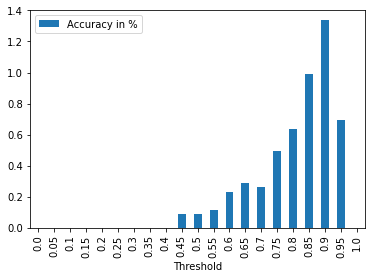

In [ ]:
#plot accuracy for multi-label bart
labels = df_multilabel_bart["labels"]
scores = df_multilabel_bart["scores"]

results =[]
for threshold in np.arange(0,1.05, 0.05):
  results.append([round(threshold,3), get_multi_label_accuracy(df['accept'], labels, scores, threshold )*100])
  
  multilabel_bart_accuracy = pd.DataFrame(results)

multilabel_bart_accuracy.rename(columns={multilabel_bart_accuracy.columns[0]: "Threshold", multilabel_bart_accuracy.columns[1]: "Accuracy in %" }, inplace = True)
multilabel_bart_accuracy.plot.bar(x="Threshold",y="Accuracy in %")

It seems like the best threshold would be at 0.9. This is probably due to the fact that there are many sentences labeled with only one label. High threshold automatically indicates that we will encode a lot of labeled sentences into one-labeled sentences, even though they still have high and valuable probability scores from the zero-shot classification. The accuracy measure is therefore optimized for one-label.

###DeBERTa Model

####Model execution

In [ ]:
#took 31 min on Colab GPU
df_onelabel_deberta = zero_shot_classifier(df = df["new_text"], classifier = deberta, candidate_labels=candidate_labels, multi_label_set = False)
df_onelabel_deberta

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


,sequence,labels,scores
0,the other part of our data consists of an undirected social graph.,"[data, item, empirical result, contribution, limitation, definition, research question, goal, method, relation to literature, hypothesis result, motivation, future work, hypothesis, theory]","[0.1736992448568344, 0.14048829674720764, 0.11661738902330399, 0.08949225395917892, 0.08884341269731522, 0.06285567581653595, 0.05956932529807091, 0.057401143014431, 0.04162554442882538, 0.03744202479720116, 0.03473367542028427, 0.03162911906838417, 0.03150159493088722, 0.02167297899723053, 0.012428398244082928]"
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,"[research question, contribution, data, hypothesis, relation to literature, hypothesis result, definition, item, empirical result, limitation, method, goal, motivation, theory, future work]","[0.09619297832250595, 0.09201391786336899, 0.08962523192167282, 0.08877423405647278, 0.08496811985969543, 0.06939195096492767, 0.06593120843172073, 0.06462721526622772, 0.06428185105323792, 0.06024206802248955, 0.05938686802983284, 0.05351874232292175, 0.04403464123606682, 0.041519079357385635, 0.025491945445537567]"
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[data, contribution, item, empirical result, relation to literature, goal, method, research question, definition, limitation, motivation, hypothesis result, hypothesis, future work, theory]","[0.12737807631492615, 0.12638504803180695, 0.11954519152641296, 0.10962044447660446, 0.09995834529399872, 0.08600584417581558, 0.07004702091217041, 0.05852711573243141, 0.04732048884034157, 0.04292219877243042, 0.03530029579997063, 0.032308146357536316, 0.017622914165258408, 0.0142102912068367, 0.012848550453782082]"
3,"this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.","[empirical result, contribution, item, data, goal, relation to literature, limitation, research question, definition, motivation, hypothesis result, method, hypothesis, future work, theory]","[0.2211407870054245, 0.14816118776798248, 0.14462445676326752, 0.12699149549007416, 0.06464351713657379, 0.057031676173210144, 0.046311844140291214, 0.03764985129237175, 0.033803243190050125, 0.03293639421463013, 0.03268522024154663, 0.02426469326019287, 0.011119242757558823, 0.010384811088442802, 0.008251565508544445]"
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).","[relation to literature, contribution, empirical result, item, data, motivation, research question, goal, limitation, definition, method, hypothesis result, hypothesis, future work, theory]","[0.11560807377099991, 0.09676459431648254, 0.08269968628883362, 0.08028594404459, 0.079153873026371, 0.07054652273654938, 0.06879041343927383, 0.06825608015060425, 0.06612049043178558, 0.061837129294872284, 0.05797916278243065, 0.048863839358091354, 0.044049594551324844, 0.0314495824277401, 0.027594944462180138]"
...,...,...,...
3439,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,"[research question, item, relation to literature, contribution, goal, motivation, future work, empirical result, limitation, hypothesis result, hypothesis, data, definition, theory, method]","[0.10163853317499161, 0.10067254304885864, 0.09207439422607422, 0.09003210812807083, 0.08576782047748566, 0.08499161154031754, 0.07300961762666702, 0.07143217325210571, 0.0643940195441246, 0.05501163750886917, 0.04886934533715248, 0.04018280655145645, 0.03844500705599785, 0.0360119566321373, 0.017466355115175247]"
3440,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequ

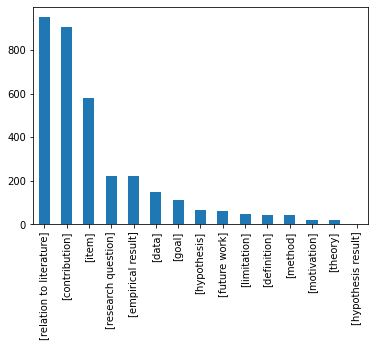

In [ ]:
#plot frequency of predicted labels for one-label deberta
freq_labels_onelabeldeberta = [labels[:1] for labels in df_onelabel_deberta.labels]
freq_labels_onelabeldeberta = pd.DataFrame({'one_label':freq_labels_onelabeldeberta})
freq_labels_onelabeldeberta['one_label'].value_counts().plot.bar()

In [ ]:
#took 33 min on Colab GPU
df_multilabel_deberta = zero_shot_classifier(df = df["new_text"], classifier = deberta, candidate_labels=candidate_labels, multi_label_set = True)
df_multilabel_deberta

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


,sequence,labels,scores
0,the other part of our data consists of an undirected social graph.,"[data, empirical result, item, limitation, contribution, future work, goal, definition, research question, method, hypothesis result, motivation, relation to literature, hypothesis, theory]","[0.43556883931159973, 0.3055952787399292, 0.2941882908344269, 0.23000024259090424, 0.16466151177883148, 0.12570242583751678, 0.06504885107278824, 0.04682988300919533, 0.0413375124335289, 0.02401946671307087, 0.020188355818390846, 0.017325736582279205, 0.014306302182376385, 0.003921190742403269, 0.0020079254172742367]"
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,"[contribution, item, hypothesis, empirical result, data, hypothesis result, research question, limitation, definition, goal, relation to literature, future work, motivation, method, theory]","[0.3124507665634155, 0.30615416169166565, 0.2559060752391815, 0.22081612050533295, 0.19631832838058472, 0.1515527218580246, 0.14725585281848907, 0.13952143490314484, 0.13007599115371704, 0.11258942633867264, 0.08662682771682739, 0.07882750034332275, 0.07167701423168182, 0.07089659571647644, 0.05733776092529297]"
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[item, contribution, empirical result, data, goal, method, relation to literature, research question, motivation, limitation, definition, hypothesis result, future work, hypothesis, theory]","[0.6009073257446289, 0.5819014310836792, 0.5676494240760803, 0.5636370778083801, 0.3635716438293457, 0.3185724914073944, 0.2855868339538574, 0.09408652037382126, 0.09095200151205063, 0.09060727059841156, 0.0787869244813919, 0.048963941633701324, 0.01583866775035858, 0.006649119779467583, 0.00396193191409111]"
3,"this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.","[empirical result, contribution, item, data, goal, relation to literature, limitation, motivation, method, definition, research question, hypothesis result, future work, hypothesis, theory]","[0.9205770492553711, 0.8650582432746887, 0.8216789960861206, 0.8006590604782104, 0.4912950396537781, 0.34575578570365906, 0.27657821774482727, 0.2724815309047699, 0.1472354680299759, 0.11907754838466644, 0.1003851369023323, 0.0794818103313446, 0.018064551055431366, 0.004536990076303482, 0.0033189307432621717]"
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).","[item, contribution, empirical result, relation to literature, limitation, motivation, definition, goal, data, method, future work, research question, hypothesis result, hypothesis, theory]","[0.45307740569114685, 0.4409002959728241, 0.43488961458206177, 0.3928176760673523, 0.3525979518890381, 0.27330276370048523, 0.2664852440357208, 0.26332753896713257, 0.2572392523288727, 0.22027456760406494, 0.11424215137958527, 0.10711683332920074, 0.09654669463634491, 0.04891177639365196, 0.02528977394104004]"
...,...,...,...
3439,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,"[future work, motivation, contribution, item, research question, goal, empirical result, limitation, relation to literature, hypothesis result, theory, hypothesis, definition, data, method]","[0.2883649468421936, 0.19755470752716064, 0.18865357339382172, 0.17060773074626923, 0.14048504829406738, 0.1303832232952118, 0.12193217873573303, 0.08814037591218948, 0.08721565455198288, 0.045953620225191116, 0.03919287770986557, 0.03171408176422119, 0.027713250368833542, 0.02043500728905201, 0.005316352937370539]"
3440,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interr

####Accuracy

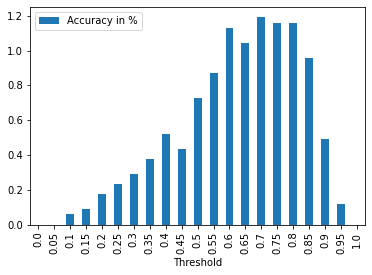

In [ ]:
#plot accuracy for multi-label deberta
labels = df_multilabel_deberta["labels"]
scores = df_multilabel_deberta["scores"]

results =[]
for threshold in np.arange(0,1.05, 0.05):
  results.append([round(threshold,3), get_multi_label_accuracy(df['accept'], labels, scores, threshold )*100])
  
  multilabel_deberta_accuracy = pd.DataFrame(results)

multilabel_deberta_accuracy.rename(columns={multilabel_deberta_accuracy.columns[0]: "Threshold", multilabel_deberta_accuracy.columns[1]: "Accuracy in %" }, inplace = True)
multilabel_deberta_accuracy.plot.bar(x="Threshold",y="Accuracy in %")

##Precise labels

After deeper knowledge in the course of labeling more sentences in Prodigy, we have identified certain patterns when classifying sentences into the categories of a research paper, i.e. certain buzzwords that are connected with a certain category. For instance, the word "studies" in a sentence is often related to the category "relation to literature". For this reason, we will try to use the below candidate labels to expect a higher accurate prediction from the zero-shot classification models.

In [23]:
candidate_labels_precise=["aim", "motivation", "research question", "studies", "method", "theory", "definition", "survey", "hypothesis", "hypothesis result", "empirical result", "insight", "limitation", "future work"]

###BART Model

####Model execution

In [ ]:
#took 22 min on Colab GPU
df_onelabel_bart_precise = zero_shot_classifier(df = df["new_text"], classifier = bart, candidate_labels=candidate_labels_precise, multi_label_set = False)
df_onelabel_bart_precise

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


,sequence,labels,scores
0,the other part of our data consists of an undirected social graph.,"[empirical result, method, research question, studies, theory, insight, survey, definition, hypothesis result, aim, hypothesis, limitation, future work, motivation]","[0.10548602789640427, 0.09679021686315536, 0.08790632337331772, 0.08419318497180939, 0.08047027885913849, 0.07769757509231567, 0.0732044205069542, 0.07072348147630692, 0.06393321603536606, 0.06304378062486649, 0.062194257974624634, 0.05062331259250641, 0.04518828168511391, 0.03854570537805557]"
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,"[research question, insight, method, theory, limitation, definition, empirical result, studies, aim, hypothesis, survey, hypothesis result, future work, motivation]","[0.09553212672472, 0.08972534537315369, 0.08438708633184433, 0.08229764550924301, 0.07912642508745193, 0.07671479880809784, 0.07098798453807831, 0.06885338574647903, 0.06713727116584778, 0.06257869303226471, 0.0614030659198761, 0.061068564653396606, 0.05891388654708862, 0.041273780167102814]"
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[studies, empirical result, survey, research question, method, aim, insight, hypothesis result, definition, theory, hypothesis, future work, limitation, motivation]","[0.16174021363258362, 0.13575513660907745, 0.0990041047334671, 0.09816116094589233, 0.07577703148126602, 0.06822742521762848, 0.05931558459997177, 0.05829131230711937, 0.0494363009929657, 0.049261681735515594, 0.04913437366485596, 0.03314124792814255, 0.03231033310294151, 0.03044401854276657]"
3,"this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.","[studies, empirical result, insight, research question, aim, theory, definition, method, survey, hypothesis result, hypothesis, limitation, motivation, future work]","[0.1491764783859253, 0.11009973287582397, 0.09575096517801285, 0.09137227386236191, 0.08535535633563995, 0.07665633410215378, 0.06082829460501671, 0.0557074137032032, 0.05354037135839462, 0.05136583000421524, 0.05073666200041771, 0.042957503348588943, 0.03920699656009674, 0.037245798856019974]"
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).","[empirical result, method, studies, theory, research question, definition, insight, hypothesis result, hypothesis, limitation, aim, survey, future work, motivation]","[0.11638274788856506, 0.11275696754455566, 0.10746926814317703, 0.09777197241783142, 0.08680947124958038, 0.0814610943198204, 0.08145581185817719, 0.06849588453769684, 0.05764723941683769, 0.05297331511974335, 0.04535859823226929, 0.038146279752254486, 0.035604994744062424, 0.017666378989815712]"
...,...,...,...
3439,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,"[method, theory, empirical result, research question, insight, definition, hypothesis result, hypothesis, limitation, aim, studies, future work, survey, motivation]","[0.16426970064640045, 0.10223709791898727, 0.08213208615779877, 0.07768351584672928, 0.07495617121458054, 0.07176339626312256, 0.069755919277668, 0.06505703181028366, 0.057204872369766235, 0.056575875729322433, 0.05621665343642235, 0.049210112541913986, 0.04119574651122093, 0.03174181655049324]"
3440,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interruptions, and the mechanisms that or personnel deployed to cope with and recover from coordination breakdowns.","[research question, studies, insight, aim, method, empirical result, theory, definition, survey, future work, hypothesis, limitation, hypothesis resu

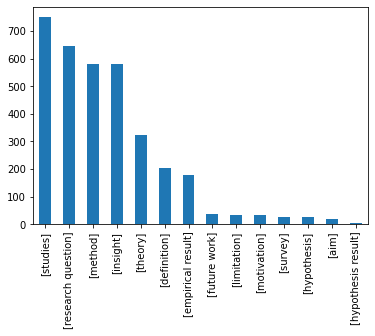

In [ ]:
#plot frequency of predicted labels for one-label bart with precise candidate_labels
freq_labels_onelabelbart_precise = [labels[:1] for labels in df_onelabel_bart_precise.labels]
freq_labels_onelabelbart_precise = pd.DataFrame({'one_label':freq_labels_onelabelbart_precise})
freq_labels_onelabelbart_precise['one_label'].value_counts().plot.bar()

In [24]:
#took 21 min on Colab GPU
df_multilabel_bart_precise = zero_shot_classifier(df = df["new_text"], classifier = bart, candidate_labels=candidate_labels_precise, multi_label_set = False)
df_multilabel_bart_precise

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


,sequence,labels,scores
0,the other part of our data consists of an undirected social graph.,"[empirical result, method, research question, studies, theory, insight, survey, definition, hypothesis result, aim, hypothesis, limitation, future work, motivation]","[0.10548602789640427, 0.09679021686315536, 0.08790632337331772, 0.08419318497180939, 0.08047027885913849, 0.07769757509231567, 0.0732044205069542, 0.07072348147630692, 0.06393321603536606, 0.06304378062486649, 0.062194257974624634, 0.05062331259250641, 0.04518828168511391, 0.03854570537805557]"
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,"[research question, insight, method, theory, limitation, definition, empirical result, studies, aim, hypothesis, survey, hypothesis result, future work, motivation]","[0.09553212672472, 0.08972534537315369, 0.08438708633184433, 0.08229764550924301, 0.07912642508745193, 0.07671479880809784, 0.07098798453807831, 0.06885338574647903, 0.06713727116584778, 0.06257869303226471, 0.0614030659198761, 0.061068564653396606, 0.05891388654708862, 0.041273780167102814]"
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[studies, empirical result, survey, research question, method, aim, insight, hypothesis result, definition, theory, hypothesis, future work, limitation, motivation]","[0.16174021363258362, 0.13575513660907745, 0.0990041047334671, 0.09816116094589233, 0.07577703148126602, 0.06822742521762848, 0.05931558459997177, 0.05829131230711937, 0.0494363009929657, 0.049261681735515594, 0.04913437366485596, 0.03314124792814255, 0.03231033310294151, 0.03044401854276657]"
3,"this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.","[studies, empirical result, insight, research question, aim, theory, definition, method, survey, hypothesis result, hypothesis, limitation, motivation, future work]","[0.1491764783859253, 0.11009973287582397, 0.09575096517801285, 0.09137227386236191, 0.08535535633563995, 0.07665633410215378, 0.06082829460501671, 0.0557074137032032, 0.05354037135839462, 0.05136583000421524, 0.05073666200041771, 0.042957503348588943, 0.03920699656009674, 0.037245798856019974]"
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).","[empirical result, method, studies, theory, research question, definition, insight, hypothesis result, hypothesis, limitation, aim, survey, future work, motivation]","[0.11638274788856506, 0.11275696754455566, 0.10746926814317703, 0.09777197241783142, 0.08680947124958038, 0.0814610943198204, 0.08145581185817719, 0.06849588453769684, 0.05764723941683769, 0.05297331511974335, 0.04535859823226929, 0.038146279752254486, 0.035604994744062424, 0.017666378989815712]"
...,...,...,...
3439,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,"[method, theory, empirical result, research question, insight, definition, hypothesis result, hypothesis, limitation, aim, studies, future work, survey, motivation]","[0.16426970064640045, 0.10223709791898727, 0.08213208615779877, 0.07768351584672928, 0.07495617121458054, 0.07176339626312256, 0.069755919277668, 0.06505703181028366, 0.057204872369766235, 0.056575875729322433, 0.05621665343642235, 0.049210112541913986, 0.04119574651122093, 0.03174181655049324]"
3440,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interruptions, and the mechanisms that or personnel deployed to cope with and recover from coordination breakdowns.","[research question, studies, insight, aim, method, empirical result, theory, definition, survey, future work, hypothesis, limitation, hypothesis resu

####Accuracy

In [25]:
#encoding labels with keras Lookup Layer
terms = tf.ragged.constant(df["accept"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print(f"Vocabulary: {vocab}")
#the UNK token will always be returned, we need to sort our outputs according to this vocabulary list

Vocabulary: ['[UNK]', 'Theory', 'RelationToLiterature', 'Definition', 'Method', 'EmpiricalResult', 'Data', 'Motivation', 'Limitation', 'Contribution', 'Item', 'ResearchQuestion', 'Goal', 'FutureWork', 'HypothesisResult', 'Hypothesis']


In [26]:
#Multi Label Accuracy For Multiple Labels Classification Models (https://data4thought.com/toxic_comments_transformer.html)
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [27]:
#sort order with precise candidate_labels
labels = df_multilabel_bart_precise["labels"]
scores = df_multilabel_bart_precise["scores"]

SORT_ORDER = {"[UNK]": 0, "theory": 1, "studies": 2, "method": 3, "definition": 4, "empirical result": 5, 
              "insight": 6, "motivation" : 7, "data": 8, "survey": 9, "aim": 10, "limitation": 11, "hypothesis result": 12,
              "future work": 13, "research question": 14, "hypothesis": 15}

def order_preds(labels, scores, threshold):
  """takes the predictions from zero shot (labels and scores), zips thems, orders them into the correct order to calculate the multi_label_accuracy
  and binarizes them based on a given threshold"""
  ordered_preds = []
  for idx in range(len(labels)):
    sub_list = [list(a) for a in zip(labels[idx], scores[idx])]
    sub_list.append(["[UNK]", 0.0])
    sub_list.sort(key=lambda val: SORT_ORDER[val[0]])
    sub_list = np.asarray(sub_list)
    sub_array = np.array(sub_list[:,1], dtype = "float32")
    sub_array[sub_array >= threshold] = 1
    sub_array[sub_array < threshold] = 0
    ordered_preds.append(sub_array)
  return np.array(ordered_preds)

In [28]:
def get_multi_label_accuracy(true_labels, labels, score, threshold):
  """combined the creation of ordered preds with the calculation of the multi_label_accuracy;
  true_labels are in the form of a pd.Series (e.g., df["labels"]),
  labels are the labels in the order given by the result of zero-shot-classification,
  score are the scores in the order given by the result of zero-shot classification"""
  #get the binarized arrays in the correct order, binarized based on a given threshold
  preds = order_preds(labels, scores, threshold)

  #get the binarized labels as tensor
  labels_tf = tf.ragged.constant(true_labels.values)
  label_binarized = lookup(labels_tf)

  #turn ordered preds given the threshold to tensor
  preds_tf = tf.convert_to_tensor(preds, dtype=tf.float32)

  return multi_label_accuracy(label_binarized, preds_tf).numpy()

In [ ]:
#plot accuracy for multi-label bart
labels = df_multilabel_bart_precise["labels"]
scores = df_multilabel_bart_precise["scores"]

results =[]
for threshold in np.arange(0,1.05, 0.05):
  results.append([round(threshold,3), get_multi_label_accuracy(df['accept'], labels, scores, threshold )*100])
  
  multilabel_bart_accuracy = pd.DataFrame(results)

multilabel_bart_accuracy.rename(columns={multilabel_bart_accuracy.columns[0]: "Threshold", multilabel_bart_accuracy.columns[1]: "Accuracy in %" }, inplace = True)
multilabel_bart_accuracy.plot.bar(x="Threshold",y="Accuracy in %")

###DeBERTa Model

####Model execution

In [ ]:
#took ~45 min on Colab GPU
df_onelabel_deberta_precise = zero_shot_classifier(df = df["new_text"], classifier = deberta, candidate_labels=candidate_labels_precise, multi_label_set = False)
df_onelabel_deberta_precise

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


,sequence,labels,scores
0,the other part of our data consists of an undirected social graph.,"[empirical result, limitation, insight, aim, definition, research question, method, hypothesis result, motivation, future work, survey, hypothesis, studies, theory]","[0.1694878786802292, 0.12912209331989288, 0.11153106391429901, 0.09883560985326767, 0.09135237336158752, 0.08657610416412354, 0.06049719825387001, 0.050480786710977554, 0.04596872627735138, 0.0457833856344223, 0.03763866052031517, 0.03149879723787308, 0.023164335638284683, 0.018063025549054146]"
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,"[insight, research question, hypothesis, aim, hypothesis result, definition, empirical result, studies, limitation, method, motivation, theory, survey, future work]","[0.13800963759422302, 0.10469722747802734, 0.09662260860204697, 0.0852220207452774, 0.07552676647901535, 0.07176006585359573, 0.06996490061283112, 0.06629247218370438, 0.06556796282529831, 0.06463715434074402, 0.04792766273021698, 0.04518970847129822, 0.040836114436388016, 0.027745641767978668]"
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[aim, insight, empirical result, studies, method, research question, survey, definition, limitation, motivation, hypothesis result, hypothesis, future work, theory]","[0.16556739807128906, 0.13505321741104126, 0.12829022109508514, 0.12361744791269302, 0.08197692781686783, 0.06849503517150879, 0.05997292697429657, 0.055379778146743774, 0.050232402980327606, 0.04131238907575607, 0.03781064227223396, 0.020624324679374695, 0.016630487516522408, 0.01503682415932417]"
3,"this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.","[empirical result, insight, studies, aim, limitation, research question, definition, motivation, hypothesis result, method, survey, hypothesis, future work, theory]","[0.26255881786346436, 0.21098975837230682, 0.13217945396900177, 0.09851992875337601, 0.05498570203781128, 0.044701386243104935, 0.04013433679938316, 0.0391051359474659, 0.038806915283203125, 0.028809286653995514, 0.013880668208003044, 0.013201793655753136, 0.012329807505011559, 0.009797021746635437]"
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).","[studies, insight, empirical result, motivation, research question, aim, limitation, definition, method, hypothesis result, hypothesis, future work, survey, theory]","[0.10891426354646683, 0.10415227711200714, 0.0991242304444313, 0.08455739170312881, 0.08245250582695007, 0.08193616569042206, 0.07925233244895935, 0.07411827147006989, 0.0694940909743309, 0.058568425476551056, 0.05279804766178131, 0.037695616483688354, 0.03386084362864494, 0.03307542949914932]"
...,...,...,...
3439,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,"[research question, motivation, aim, insight, future work, empirical result, studies, limitation, hypothesis result, hypothesis, definition, theory, survey, method]","[0.11983180791139603, 0.10020509362220764, 0.0965602919459343, 0.08985810726881027, 0.08607832342386246, 0.08421850949525833, 0.08143753558397293, 0.07592053711414337, 0.06485870480537415, 0.0576169453561306, 0.045326657593250275, 0.04245808720588684, 0.03503650426864624, 0.02059282921254635]"
3440,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interruptions, and the mechanisms that or personnel deployed to cope with and recover from coordination breakdowns.","[aim, insight, method, studies, empirical result, limitation, research question, definition, motivation, hypothesis result, survey, future

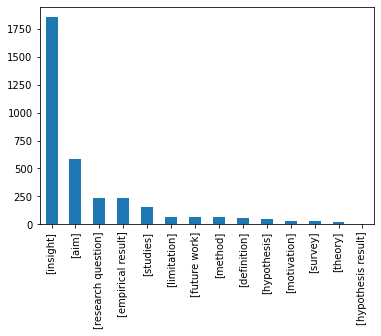

In [ ]:
#plot frequency of predicted labels for one-label deberta with precise candidate_labels
freq_labels_onelabeldeberta_precise = [labels[:1] for labels in df_onelabel_deberta_precise.labels]
freq_labels_onelabeldeberta_precise = pd.DataFrame({'one_label':freq_labels_onelabeldeberta_precise})
freq_labels_onelabeldeberta_precise['one_label'].value_counts().plot.bar()

In [30]:
#took 23 min on Colab GPU
df_multilabel_deberta_precise = zero_shot_classifier(df = df["new_text"], classifier = bart, candidate_labels=candidate_labels_precise, multi_label_set = False)
df_multilabel_deberta_precise

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


,sequence,labels,scores
0,the other part of our data consists of an undirected social graph.,"[empirical result, method, research question, studies, theory, insight, survey, definition, hypothesis result, aim, hypothesis, limitation, future work, motivation]","[0.10548602789640427, 0.09679021686315536, 0.08790632337331772, 0.08419318497180939, 0.08047027885913849, 0.07769757509231567, 0.0732044205069542, 0.07072348147630692, 0.06393321603536606, 0.06304378062486649, 0.062194257974624634, 0.05062331259250641, 0.04518828168511391, 0.03854570537805557]"
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,"[research question, insight, method, theory, limitation, definition, empirical result, studies, aim, hypothesis, survey, hypothesis result, future work, motivation]","[0.09553212672472, 0.08972534537315369, 0.08438708633184433, 0.08229764550924301, 0.07912642508745193, 0.07671479880809784, 0.07098798453807831, 0.06885338574647903, 0.06713727116584778, 0.06257869303226471, 0.0614030659198761, 0.061068564653396606, 0.05891388654708862, 0.041273780167102814]"
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[studies, empirical result, survey, research question, method, aim, insight, hypothesis result, definition, theory, hypothesis, future work, limitation, motivation]","[0.16174021363258362, 0.13575513660907745, 0.0990041047334671, 0.09816116094589233, 0.07577703148126602, 0.06822742521762848, 0.05931558459997177, 0.05829131230711937, 0.0494363009929657, 0.049261681735515594, 0.04913437366485596, 0.03314124792814255, 0.03231033310294151, 0.03044401854276657]"
3,"this is supported by a more recent report by west and curtis (2006), which found significant differences between women and men academics, including disparities in tenure and salaries.","[studies, empirical result, insight, research question, aim, theory, definition, method, survey, hypothesis result, hypothesis, limitation, motivation, future work]","[0.1491764783859253, 0.11009973287582397, 0.09575096517801285, 0.09137227386236191, 0.08535535633563995, 0.07665633410215378, 0.06082829460501671, 0.0557074137032032, 0.05354037135839462, 0.05136583000421524, 0.05073666200041771, 0.042957503348588943, 0.03920699656009674, 0.037245798856019974]"
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).","[empirical result, method, studies, theory, research question, definition, insight, hypothesis result, hypothesis, limitation, aim, survey, future work, motivation]","[0.11638274788856506, 0.11275696754455566, 0.10746926814317703, 0.09777197241783142, 0.08680947124958038, 0.0814610943198204, 0.08145581185817719, 0.06849588453769684, 0.05764723941683769, 0.05297331511974335, 0.04535859823226929, 0.038146279752254486, 0.035604994744062424, 0.017666378989815712]"
...,...,...,...
3439,the algorithm changes constantly because it has no logical basis and is continuously buffeted by short-lived correlations.,"[method, theory, empirical result, research question, insight, definition, hypothesis result, hypothesis, limitation, aim, studies, future work, survey, motivation]","[0.16426970064640045, 0.10223709791898727, 0.08213208615779877, 0.07768351584672928, 0.07495617121458054, 0.07176339626312256, 0.069755919277668, 0.06505703181028366, 0.057204872369766235, 0.056575875729322433, 0.05621665343642235, 0.049210112541913986, 0.04119574651122093, 0.03174181655049324]"
3440,"we paid special attention to critical incidents where coordination efforts were interrupted or stymied, the sources and consequences of the interruptions, and the mechanisms that or personnel deployed to cope with and recover from coordination breakdowns.","[research question, studies, insight, aim, method, empirical result, theory, definition, survey, future work, hypothesis, limitation, hypothesis resu

####Accuracy

In [ ]:
#plot accuracy for multi-label deberta with precise candidate_labels
labels = df_multilabel_deberta_precise["labels"]
scores = df_multilabel_deberta_precise["scores"]

results =[]
for threshold in np.arange(0,1.05, 0.05):
  results.append([threshold, get_multi_label_accuracy(df['accept'], labels, scores, threshold )*100])
  
  multilabel_deberta_precise_accuracy = pd.DataFrame(results)

multilabel_deberta_precise_accuracy.rename(columns={multilabel_deberta_precise_accuracy.columns[0]: "Threshold", multilabel_deberta_precise_accuracy.columns[1]: "Accuracy in %" }, inplace = True)
multilabel_deberta_precise_accuracy.plot.bar(x="Threshold",y="Accuracy in %")